<a href="https://colab.research.google.com/github/hyounghe0724/StartPytorch/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import trange

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/GoogleColab/deeplearningbrov2/pytorch

/content/gdrive/My Drive/GoogleColab/deeplearningbrov2/pytorch


In [ ]:
df = pd.read_csv("./data/kospi.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [ ]:
scaler = MinMaxScaler() # 0과 1사이의 값
df[['Open','High','Low',"Close","Volume"]] = scaler.fit_transform(df[['Open','High','Low',"Close","Volume"]])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cpu is available


In [ ]:
X = df[["Open",'High',"Low","Volume"]].values
Y = df["Close"].values

In [ ]:
def seq_data(x,y,sequence_length):
  x_seq= []
  y_seq=[]
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length].tolist()) # i부터 i+sequence_length -1시점 까지 시퀀스를 저장
    y_seq.append(y[i+sequence_length]) # i+sequence_lenght의 시점의 라벨을 저장
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1,1])
# 특정 입력 길이 sequence를 기반으로 sequence_length + i 시점의 y값을 라벨로 삼는다.
# 1~5 일 -> 6일
# 7~12일 -> 13일

In [ ]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X,Y,sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [ ]:
train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size = batch_size, shuffle=False)


In [ ]:
# hyperparameters
input_size = x_seq.size(2) # [(batch_size),(sequence_length), (input_features)]
hidden_size = 8 # 은식 상태 벡터의 차원의 길이를 8로 설정
num_layers = 2 # RNN Layer갯수, 첫 번쨰 RNN layer 출력을 입력으로 받고 두 번쨰 RNN layer의 출력을 sigmoid가 받아
# 결과중 가장 큰 값의 인덱스를 출력

In [82]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
  def __ToString__(self):
    return "RNN"
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    return out

class LSTM(nn.Module):
  # Input gate, Forget Gate, Output Gate는 nn.LSTM을 호출하면 내부적으로 연산들이 설정되고 학습됨.
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length, 1)
  def __ToString__(self):
    return "LSTM"
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ =self.lstm(x,(h0, c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru  = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length, 1)
  def __ToString__(self):
    return "GRU"
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out , _ = self.gru(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [83]:
model = GRU(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [84]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model.__ToString__())


GRU


In [85]:
loss_graph = []
n = len(train_loader)
pbar = trange(num_epochs)
for epoch in pbar:
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    l = running_loss/n
    loss_graph.append(l)
    pbar.set_postfix({'epoch': epoch+1, 'loss' : l})

100%|██████████| 100/100 [00:06<00:00, 16.25it/s, epoch=100, loss=0.0014]


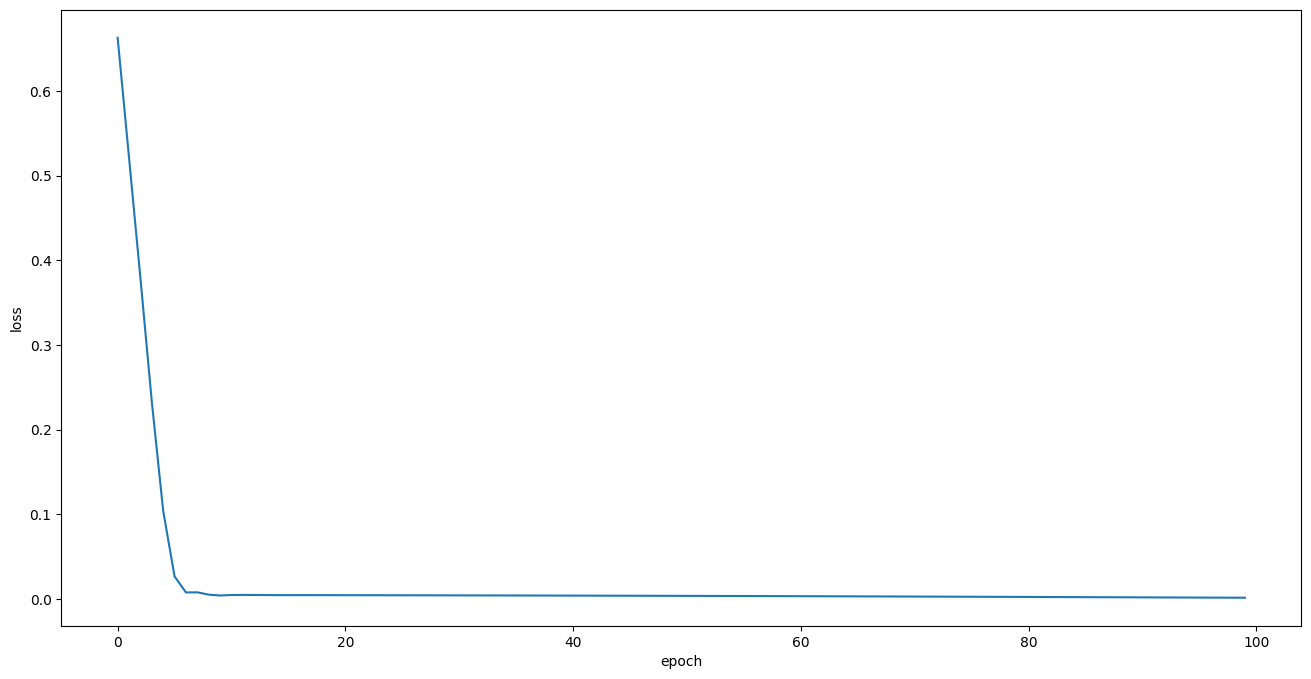

In [86]:
plt.figure(figsize=(16,8))
plt.plot(loss_graph)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

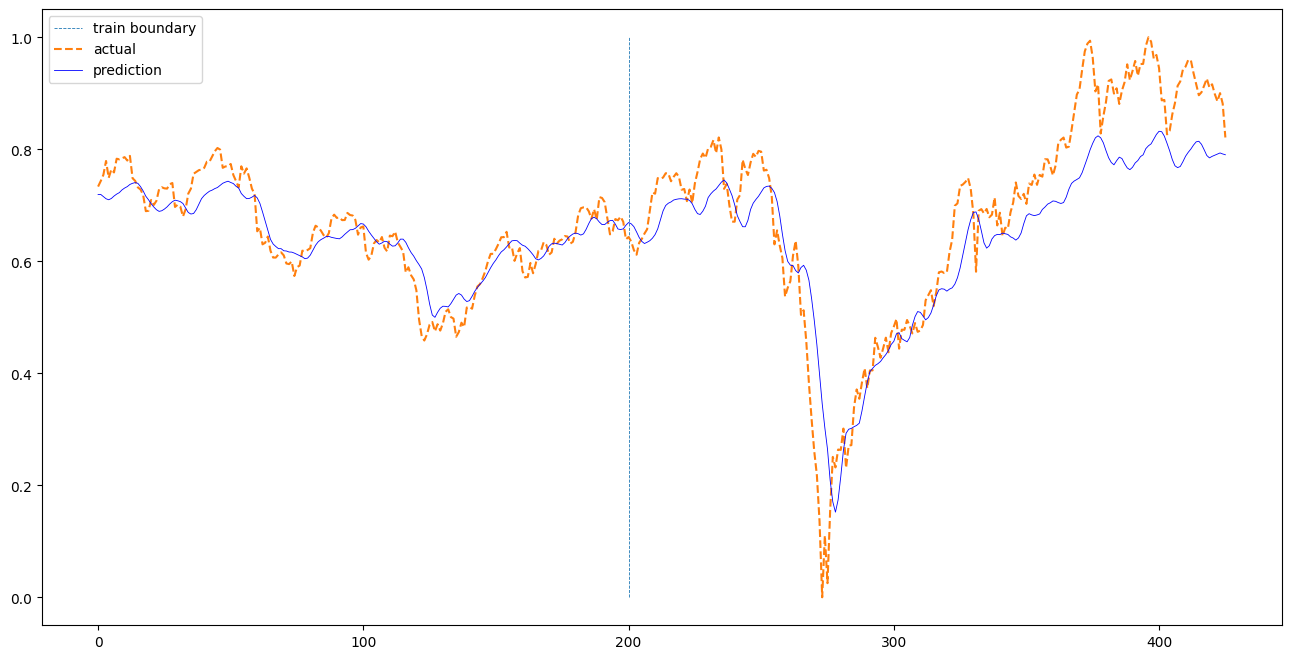

In [87]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []
    model.eval()
    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
  total = train_pred + test_pred

  plt.figure(figsize=(16,8))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, "--")
  plt.plot(total, 'b', linewidth = 0.6)
  plt.legend(['train boundary','actual', 'prediction'])
  plt.show()

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle = False)
plotting(train_loader, test_loader, df["Close"][sequence_length:].values)